<a href="https://colab.research.google.com/github/laribar/TechChallenge2/blob/main/TechChallenge_2_Rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
# Análise de dados e manipulação
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Manipulação de datas
from datetime import datetime
from pandas.tseries.offsets import BDay

# Verificação de versões (opcional)
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

Scikit-learn version: 1.6.1


In [96]:
# URL do arquivo bruto
url = 'https://raw.githubusercontent.com/laribar/TechChallenge2/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa%20(1).csv'

# Leia o CSV usando pandas, com tratamento de erros
try:
    df = pd.read_csv(url, decimal=',', thousands='.', parse_dates=['Data'], dayfirst=True)
    print("Arquivo carregado com sucesso!")
except Exception as e:
    print(f"Erro ao carregar o arquivo: {e}")
    df = None

# Verificação inicial dos dados
if df is not None:
    # Define a coluna 'Data' como índice e ordena cronologicamente
    df.set_index('Data', inplace=True)
    df.sort_index(inplace=True)

    # Exibe as primeiras linhas e informações básicas
    print("\nPrimeiras linhas do DataFrame:")
    print(df.head())
    print("\nInformações do DataFrame:")
    print(df.info())
    print("\nValores nulos por coluna:")
    print(df.isnull().sum())

Arquivo carregado com sucesso!

Primeiras linhas do DataFrame:
            Último  Abertura  Máxima  Mínima     Vol.    Var%
Data                                                         
2005-02-24   28436     27198   28436   27198  173,35M   4,55%
2005-02-25   28425     28429   28778   28178  117,64M  -0,04%
2005-02-28   28139     28423   28555   27799   71,01M  -1,01%
2005-03-01   27730     28135   28137   27643  102,72M  -1,45%
2005-03-02   28200     27730   28200   27498   82,65M   1,69%

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4956 entries, 2005-02-24 to 2025-02-24
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Último    4956 non-null   int64 
 1   Abertura  4956 non-null   int64 
 2   Máxima    4956 non-null   int64 
 3   Mínima    4956 non-null   int64 
 4   Vol.      4955 non-null   object
 5   Var%      4956 non-null   object
dtypes: int64(4), object(2)
memory usage: 271.0+

In [97]:
# Função para converter a coluna 'Vol.'
def convert_volume(value):
    if pd.isna(value):
        return np.nan
    if 'B' in value:
        return float(value.replace('B', '').replace(',', '.')) * 1e9
    if 'M' in value:
        return float(value.replace('M', '').replace(',', '.')) * 1e6
    elif 'K' in value:
        return float(value.replace('K', '').replace(',', '.')) * 1e3
    else:
        return float(value.replace(',', '.'))

# Aplica a conversão na coluna 'Vol.'
df['Vol.'] = df['Vol.'].apply(convert_volume)

# Converte a coluna 'Var%' para numérico
df['Var%'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)

# Preenche valores nulos na coluna 'Vol.' com a média
df['Vol.'].fillna(df['Vol.'].mean(), inplace=True)

# Renomeia as colunas
df.rename(columns={
    'Último': 'Fechamento',
    'Abertura': 'Abertura',
    'Máxima': 'Maxima',
    'Mínima': 'Minima',
    'Vol.': 'Volume',
    'Var%': 'Variacao'
}, inplace=True)

# Verifica os tipos de dados e valores nulos
print("\nInformações do DataFrame após tratamento:")
print(df.info())
print("\nValores nulos por coluna:")
print(df.isnull().sum())


Informações do DataFrame após tratamento:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4956 entries, 2005-02-24 to 2025-02-24
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Fechamento  4956 non-null   int64  
 1   Abertura    4956 non-null   int64  
 2   Maxima      4956 non-null   int64  
 3   Minima      4956 non-null   int64  
 4   Volume      4956 non-null   float64
 5   Variacao    4956 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 271.0 KB
None

Valores nulos por coluna:
Fechamento    0
Abertura      0
Maxima        0
Minima        0
Volume        0
Variacao      0
dtype: int64


<ipython-input-97-0a3515ce8069>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Vol.'].fillna(df['Vol.'].mean(), inplace=True)



Correlação das features com o Fechamento:
Fechamento      1.000000
Minima          0.999732
Maxima          0.999668
Abertura        0.999233
Lag1            0.999229
Min5            0.998987
Max5            0.998725
Lag2            0.998571
SMA10           0.998027
Lag3            0.997886
Lag4            0.997203
Lag5            0.996538
SMA20           0.995467
BB_lower        0.994273
BB_upper        0.991263
SMA50           0.987318
Volatility5     0.277560
MACD            0.129403
Volume          0.128860
RSI             0.032142
Daily_Return    0.008378
Variacao        0.008366
Name: Fechamento, dtype: float64


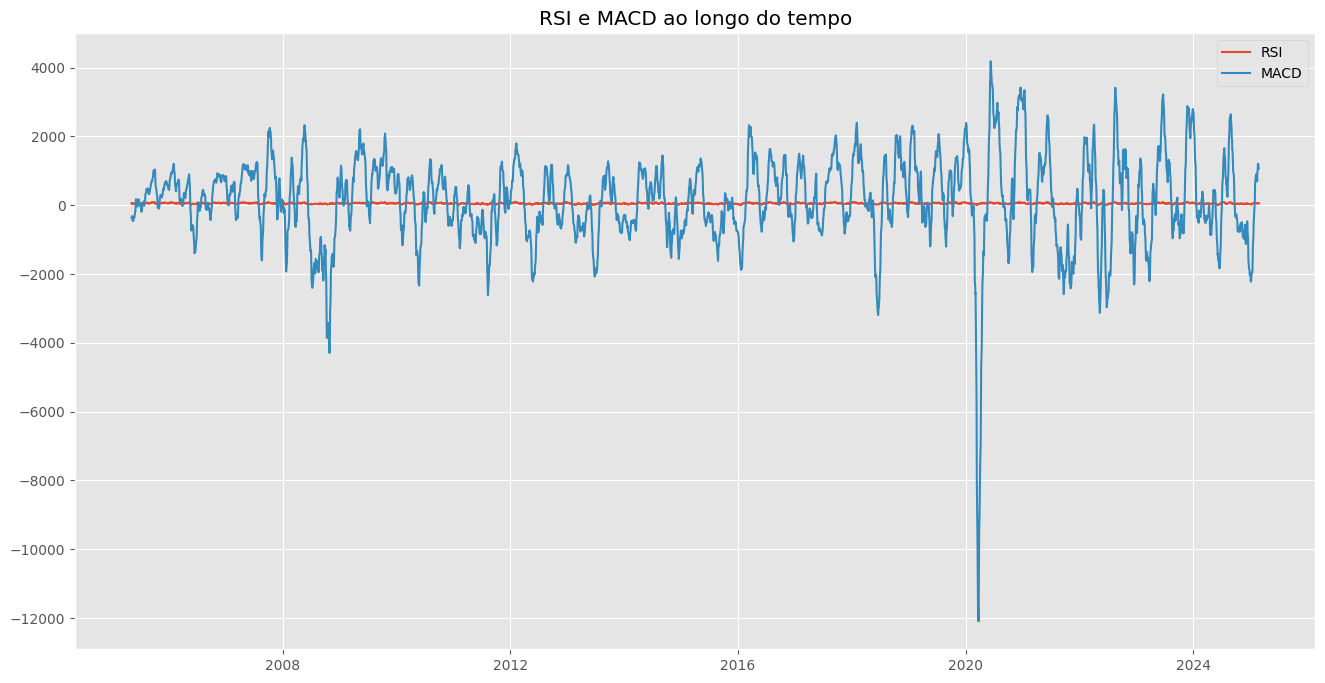

In [98]:
# 🔹 2️⃣ Feature Engineering
# Lags
df['Lag1'] = df['Fechamento'].shift(1)
df['Lag2'] = df['Fechamento'].shift(2)
df['Lag3'] = df['Fechamento'].shift(3)
df['Lag4'] = df['Fechamento'].shift(4)
df['Lag5'] = df['Fechamento'].shift(5)

# Retorno diário
df['Daily_Return'] = df['Fechamento'].pct_change()

# 🔹 Médias móveis
df['SMA10'] = df['Fechamento'].rolling(window=10).mean()
df['SMA20'] = df['Fechamento'].rolling(window=20).mean()
df['SMA50'] = df['Fechamento'].rolling(window=50).mean()

# 🔹 Volatilidade e estatísticas recentes
df['Volatility5'] = df['Fechamento'].rolling(window=5).std()
df['Max5'] = df['Fechamento'].rolling(window=5).max()
df['Min5'] = df['Fechamento'].rolling(window=5).min()

# 🔹 Bandas de Bollinger
df['BB_upper'] = df['SMA20'] + (df['Fechamento'].rolling(window=20).std() * 2)
df['BB_lower'] = df['SMA20'] - (df['Fechamento'].rolling(window=20).std() * 2)

# 🔹 Índice de Força Relativa (RSI)
delta = df['Fechamento'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# 🔹 MACD
df['MACD'] = df['Fechamento'].ewm(span=12, adjust=False).mean() - df['Fechamento'].ewm(span=26, adjust=False).mean()

# Remove valores nulos gerados pelas features
df.dropna(inplace=True)

# Verifica a correlação das features com o target
correlation = df.corr()['Fechamento'].sort_values(ascending=False)
print("\nCorrelação das features com o Fechamento:")
print(correlation)

# Visualização das features
plt.figure(figsize=(16, 8))
plt.plot(df['RSI'], label='RSI')
plt.plot(df['MACD'], label='MACD')
plt.legend()
plt.title('RSI e MACD ao longo do tempo')
plt.show()

In [99]:
# Prever o fechamento do próximo dia
df['Target'] = df['Fechamento'].shift(-1)
df.dropna(inplace=True)

# Separar treino e teste com base na data
split_date = df.index[int(len(df) * 0.8)]
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Daily_Return', 'SMA10', 'SMA20', 'SMA50',
        'Volatility5', 'Max5', 'Min5', 'BB_upper', 'BB_lower', 'RSI', 'MACD']]
y = df['Target']

# Divisão temporal
X_train = X[X.index <= split_date]
X_test = X[X.index > split_date]
y_train = y[y.index <= split_date]
y_test = y[y.index > split_date]

# Normalização (opcional, mas recomendado para alguns modelos)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar o modelo
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

# Avaliar importância das features
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
print("\nImportância das Features:")
print(feature_importances.sort_values(ascending=False))


Importância das Features:
Lag1            0.831990
Min5            0.101547
Max5            0.052869
Lag2            0.004518
SMA20           0.001672
SMA50           0.001652
SMA10           0.001457
Daily_Return    0.001319
BB_upper        0.000815
BB_lower        0.000811
Lag3            0.000275
RSI             0.000248
Lag5            0.000231
MACD            0.000224
Volatility5     0.000214
Lag4            0.000160
dtype: float64


In [105]:
y_pred = rf.predict(X_test_scaled)

In [107]:
from sklearn.metrics import mean_squared_error

# Calcular o MSE
mse = mean_squared_error(y_test, y_pred)

# Calcular o RMSE manualmente
rmse = mse ** 0.5

print(f"RMSE: {rmse:.2f}")


RMSE: 5327.70


In [110]:
# Criar uma cópia do DataFrame para não modificar o original
df_future = df.copy()

# Lista para armazenar as previsões
future_predictions = []

# Número de dias a prever
n_days = 5

for _ in range(n_days):
    # Preparar features para o próximo dia (última linha disponível)
    last_features = df_future[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5',
                               'Daily_Return', 'SMA10', 'SMA20', 'SMA50',
                               'Volatility5', 'Max5', 'Min5', 'BB_upper',
                               'BB_lower', 'RSI', 'MACD']].iloc[[-1]]

    # Fazer a previsão
    next_day_pred = rf.predict(last_features)[0]
    future_predictions.append(next_day_pred)

    # Atualizar o DataFrame com a nova previsão
    new_date = df_future.index[-1] + BDay(1)
    new_row = {
        'Fechamento': next_day_pred,
        'Lag1': df_future['Fechamento'].iloc[-1],  # Atualiza Lag1 com o último valor real
        'Lag2': df_future['Lag1'].iloc[-1],
        'Lag3': df_future['Lag2'].iloc[-1],
        'Lag4': df_future['Lag3'].iloc[-1],
        'Lag5': df_future['Lag4'].iloc[-1],
        'Daily_Return': (next_day_pred / df_future['Fechamento'].iloc[-1]) - 1,
    }

    # Adicionar a nova linha ao DataFrame
    df_future.loc[new_date] = new_row

    # Recalcular features dinâmicas (médias móveis, volatilidade, etc.)
    df_future['SMA10'] = df_future['Fechamento'].rolling(window=10).mean()
    df_future['SMA20'] = df_future['Fechamento'].rolling(window=20).mean()
    df_future['Volatility5'] = df_future['Fechamento'].rolling(window=5).std()
    df_future['BB_upper'] = df_future['SMA20'] + (df_future['Fechamento'].rolling(window=20).std() * 2)
    df_future['BB_lower'] = df_future['SMA20'] - (df_future['Fechamento'].rolling(window=20).std() * 2)
    # ... (recalcular RSI, MACD, etc. conforme necessário)

# Gerar datas futuras
future_dates = [df.index[-1] + BDay(i) for i in range(1, n_days + 1)]

# Exibir resultados
print("\nPrevisões para os próximos 5 dias úteis:")
for date, pred in zip(future_dates, future_predictions):
    print(f"{date.strftime('%Y-%m-%d')}: {pred:.2f}")


Previsões para os próximos 5 dias úteis:
2025-02-24: 121391.94
2025-02-25: 96337.93
2025-02-26: 96295.80
2025-02-27: 96649.19
2025-02-28: 96649.19


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


<ipython-input-111-623aee96458a>:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


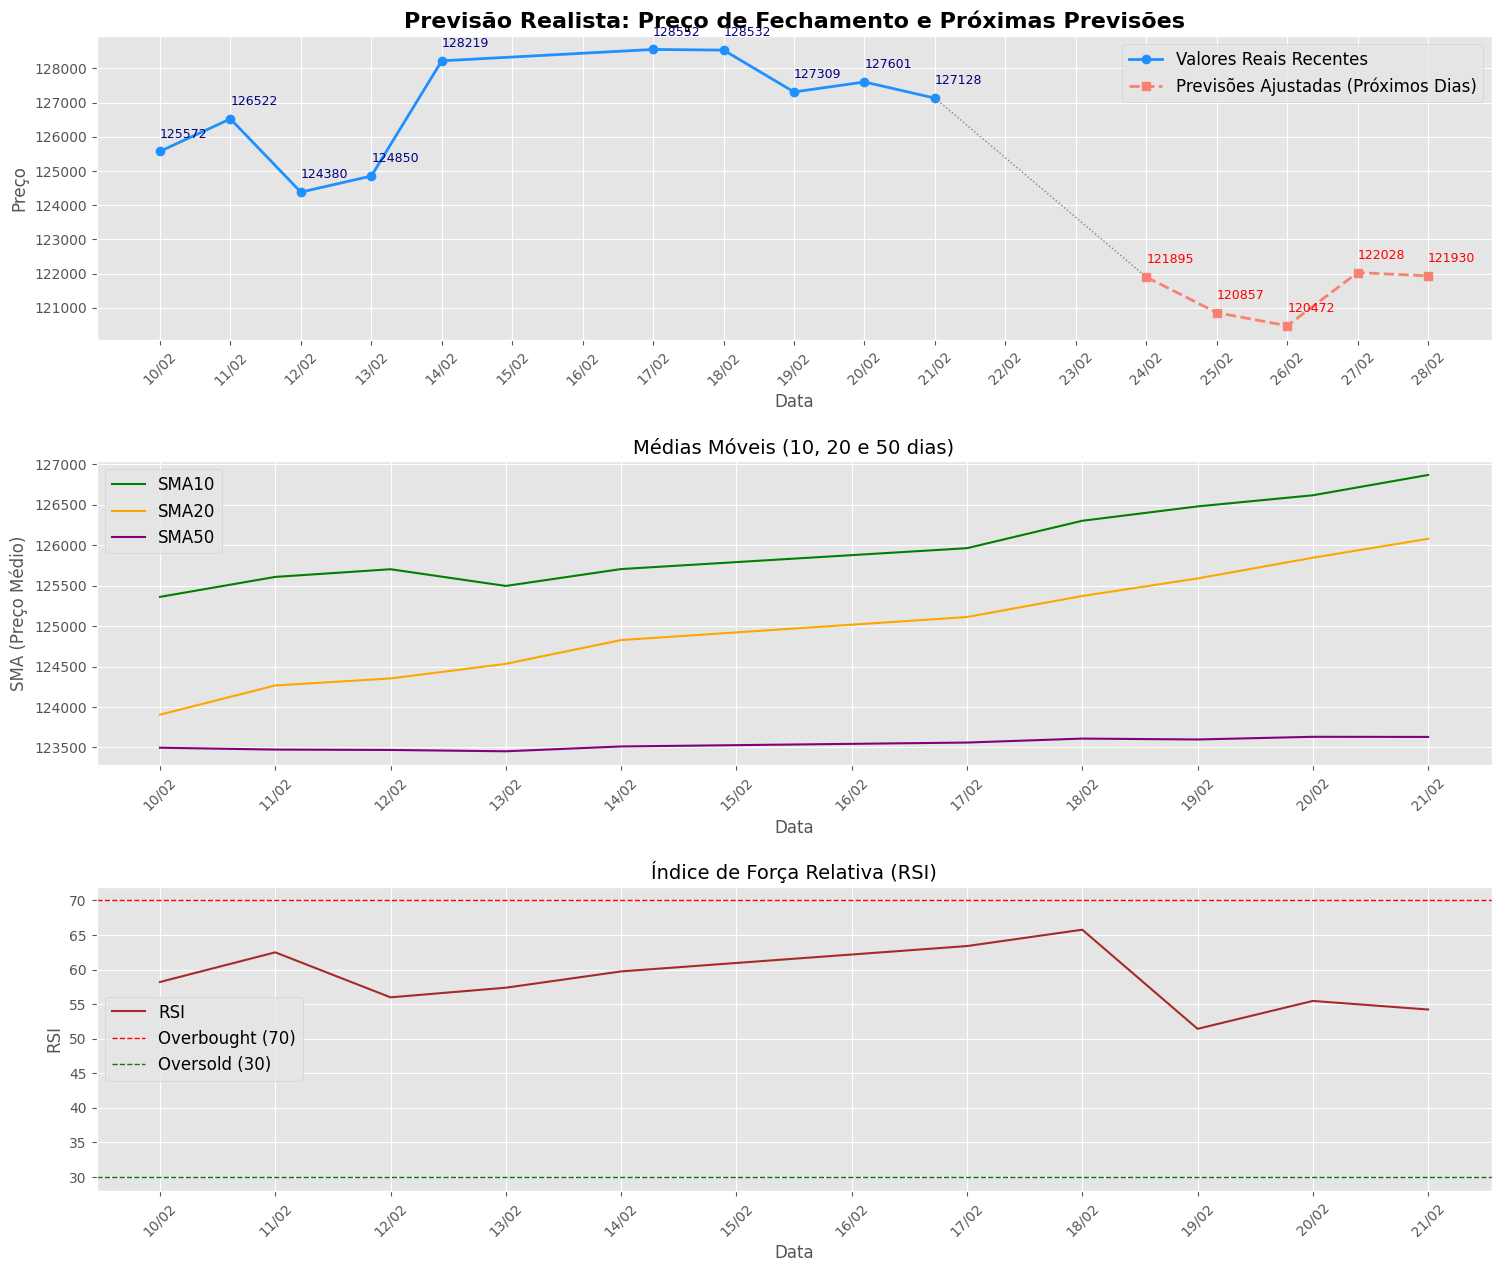

In [111]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Convertendo os índices para o formato datetime
df.index = pd.to_datetime(df.index)
future_features.index = pd.to_datetime(future_features.index)

# Configurando o estilo
plt.style.use('ggplot')

# Criando subgráficos: Principal (Fechamento e Previsões) e Indicadores
fig, axes = plt.subplots(3, 1, figsize=(18, 15), gridspec_kw={'hspace': 0.4})

# Gráfico Principal: Fechamento e Previsões
ax1 = axes[0]
ax1.plot(df.index[-10:], df['Fechamento'][-10:], label='Valores Reais Recentes', color='dodgerblue', marker='o', linewidth=2)
ax1.plot([df.index[-1], future_features.index[0]],
         [df['Fechamento'].iloc[-1], future_predictions_adjusted[0]], color='gray', linestyle='dotted', linewidth=1)
ax1.plot(future_features.index, future_predictions_adjusted, label='Previsões Ajustadas (Próximos Dias)',
         color='salmon', linestyle='--', marker='s', linewidth=2)

# Formatação do eixo X
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Configuração para marcar cada dia
ax1.tick_params(axis='x', rotation=45)

# Rótulos e anotações no gráfico principal
for date, value in zip(df.index[-10:], df['Fechamento'][-10:]):
    ax1.annotate(f'{value:.0f}', xy=(date, value), xytext=(0, 10), textcoords='offset points', fontsize=9, color='navy')
for date, prediction in zip(future_features.index, future_predictions_adjusted):
    ax1.annotate(f'{prediction:.0f}', xy=(date, prediction), xytext=(0, 10), textcoords='offset points', fontsize=9, color='red')

# Configurações do Gráfico Principal
ax1.set_title('Previsão Realista: Preço de Fechamento e Próximas Previsões', fontsize=16, fontweight='bold')
ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Preço', fontsize=12)
ax1.legend(fontsize=12)

# Gráfico 2: Médias Móveis (SMA10, SMA20, SMA50)
ax2 = axes[1]
ax2.plot(df.index[-10:], df['SMA10'][-10:], label='SMA10', color='green', linewidth=1.5)
ax2.plot(df.index[-10:], df['SMA20'][-10:], label='SMA20', color='orange', linewidth=1.5)
ax2.plot(df.index[-10:], df['SMA50'][-10:], label='SMA50', color='purple', linewidth=1.5)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax2.tick_params(axis='x', rotation=45)

ax2.set_title('Médias Móveis (10, 20 e 50 dias)', fontsize=14)
ax2.set_xlabel('Data', fontsize=12)
ax2.set_ylabel('SMA (Preço Médio)', fontsize=12)
ax2.legend(fontsize=12)

# Gráfico 3: RSI com linhas de referência (70 e 30)
ax3 = axes[2]
ax3.plot(df.index[-10:], df['RSI'][-10:], label='RSI', color='brown', linestyle='-', linewidth=1.5)
ax3.axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
ax3.axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax3.tick_params(axis='x', rotation=45)

ax3.set_title('Índice de Força Relativa (RSI)', fontsize=14)
ax3.set_xlabel('Data', fontsize=12)
ax3.set_ylabel('RSI', fontsize=12)
ax3.legend(fontsize=12)

# Ajustando espaçamentos e mostrando o gráfico
plt.tight_layout()
plt.show()


In [113]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
scores = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    scores.append(mean_absolute_error(y_test, preds))

print(f"MAE Cross-Validation: {np.mean(scores):.2f} ± {np.std(scores):.2f}")

MAE Cross-Validation: 5014.09 ± 6795.22


In [114]:
residuals = y_test - rf_predictions
plt.figure(figsize=(12,6))
plt.title('Distribuição dos Resíduos')
sns.histplot(residuals, kde=True)
plt.show()

NameError: name 'rf_predictions' is not defined